In [10]:
from liblet import Tree, Production, Grammar, Derivation, ProductionGraph, closure, warn, Stack, dod2table, dict2table, ff2table

# Pre-computare il predittore

In [11]:
import nbimporter
from L15 import tails, compute_first

In [12]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Facts, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Facts Question, Session -> ( Session ) Session, Facts -> Fact Facts, Facts -> ε, Fact -> ! STRING, Question -> ? STRING), S=Session)

In [13]:
FIRST = compute_first(G)
dict2table({N: ' '.join(FIRST[(N, )]) for N in G.N})

## L'insieme FOLLOW

In [14]:
def compute_follow(G, FIRST):

    FOLLOW = {N: set() for N in G.N}
    FOLLOW[G.S] |= {'#'}
    
    @closure
    def comlpete_follow(FOLLOW):
        for N, α in G.P:
            for γ in tails(α):
                A, β = γ[0], γ[1:]
                if A not in G.N: continue
                FOLLOW[A] |= FIRST[β] - {'ε'}
                if 'ε' in FIRST[β]: FOLLOW[A] |= FOLLOW[N]
        return FOLLOW

    return comlpete_follow(FOLLOW)

In [15]:
FOLLOW = compute_follow(G, FIRST)
dict2table({N: ' '.join(FOLLOW[N]) for N in G.N})

## Strong LL(1)

In [16]:
def compute_table(G, FIRST, FOLLOW):
    
    TABLE = {N: dict()  for N in G.N}
    FIRST_TABLE = {N: dict()  for N in G.N}
    FOLLOW_TABLE = {N: dict()  for N in G.N}

    for P in G.P:
        A, α = P
        for a in FIRST[α] - {'ε'}:
            if a in FIRST_TABLE[A]:
                warn('First/first conflict on ({}, {}) for production {}'.format(A, a, P))
            else:
                FIRST_TABLE[A][a] = P
                TABLE[A][a] = P
        if 'ε' in FIRST[α]:
            for a in FOLLOW[A]:
                if a in FIRST_TABLE[A]:
                    warn('First/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if a in FOLLOW_TABLE[A]:
                    warn('Follow/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if not (a in FIRST_TABLE[A] or a in FOLLOW_TABLE[A]):
                    FOLLOW_TABLE[A][a] = P
                    TABLE[A][a] = P
    return TABLE

In [17]:
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

In [18]:
def parse(G, TABLE, INPUT):
    deriv = Derivation(G)
    rest = tuple(INPUT) + ('#', )
    stack = Stack(['#', G.S])
    while stack:
        top = stack.pop()
        if top == 'ε': continue
        if top in G.T | {'#'}:
            if rest[0] == top: 
                rest = rest[1:]
            else:
                warn('Expecting {}, got {}.'.format(top, rest[0]))
                return None
        else:
            A, a = top, rest[0]
            if not a in TABLE[A]:
                warn('No prediction for ({}, {}) at {}.'.format(A, a, deriv) )
                return None                 
            pred = TABLE[A][a]
            deriv = deriv.leftmost(G.P.index(pred))
            for X in pred.rhs[::-1]: stack.push(X)
    return deriv

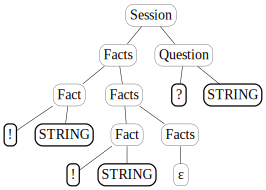

In [19]:
d = parse(G, TABLE, '! STRING ! STRING ? STRING #'.split())
ProductionGraph(d)

# Conflitti

## First/First

In [11]:
G = Grammar.from_string("""
S -> a | A
A -> a
""")

In [12]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
ff2table(G, FIRST, FOLLOW)

In [13]:
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

First/first conflict on (S, a) for production S -> A


## First/Follow

In [14]:
G = Grammar.from_string("""
S -> A a
A -> a | ε
""")

In [15]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
ff2table(G, FIRST, FOLLOW)

In [16]:
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

First/follow conflict on (A, a) for production A -> ε


## Follow/Follow

In [17]:
G = Grammar.from_string("""
S -> A a 
A -> B | C
B -> ε
C -> ε
""")

In [18]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
ff2table(G, FIRST, FOLLOW)

In [19]:
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

Follow/follow conflict on (A, a) for production A -> C


# Eliminazione dei conflitti per fattorizzazione

In [20]:
G = Grammar.from_string("""
E  -> T + T | T
T  -> F * F | F 
F  -> ( E ) | i
""")

In [22]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

First/first conflict on (E, i) for production E -> T
First/first conflict on (E, () for production E -> T
First/first conflict on (T, i) for production T -> F
First/first conflict on (T, () for production T -> F


In [23]:
G = Grammar.from_string("""
E  -> T E’ 
E’ -> + T | ε
T  -> F T’
T’ -> * F | ε
F  -> ( E ) | i
""")

In [24]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

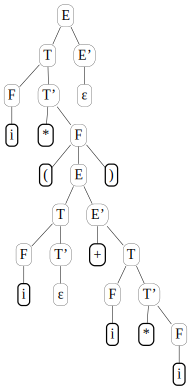

In [26]:
ProductionGraph(parse(G, TABLE, 'i * ( i + i * i )'.split()))

In [27]:
G = Grammar.from_string("""
E  -> T E’ 
E’ -> + T E’ | ε
T  -> F T’
T’ -> * F T’ | ε
F  -> ( E ) | i
""")

In [28]:
FIRST = compute_first(G)
FOLLOW = compute_follow(G, FIRST)
TABLE = compute_table(G, FIRST, FOLLOW)
dod2table(TABLE)

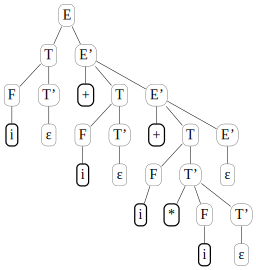

In [29]:
ProductionGraph(parse(G, TABLE, 'i + i + i * i'.split()))

# LL(1) e Recursive Descent

## Riconoscimento

In [31]:
def consume(t):        
    global look_ahead
    if look_ahead != t:
        warn('Expecting {}, found {}'.format(t, look_ahead))
    else:
        look_ahead = next(input_iterator, '#')
        
def parse_E():
    if look_ahead in {'i', '('}:
        parse_T()
        parse_Ep()
    else:
        warn('Error parsing E')

def parse_Ep():
    if look_ahead in {')', '#'}:
        pass
    elif look_ahead == '+':
        consume('+')
        parse_T()
        parse_Ep()
    else:
        warn('Error parsing E’')

def parse_T():
    if look_ahead in {'i', '('}:
        parse_F()
        parse_Tp()
    else:
        warn('Error parsing T')
    
def parse_Tp():
    if look_ahead in {'+', ')', '#'}:
        pass
    elif look_ahead == '*':
        consume('*')
        parse_F()
        parse_Tp()
    else:
        warn('Error parsing T’')

def parse_F():
    if look_ahead == 'i':
        consume('i')
    elif look_ahead == '(':
        consume('(')
        parse_E()
        consume(')')
    else:
        warn('Error parsing F')

In [35]:
input_iterator = iter('( i + i ) * i'.split())
look_ahead = next(input_iterator)

parse_E()

## Un tokenizzatore molto semplice

In [36]:
from re import finditer

def make_consume(expression):
    input_iterator = iter(_.group() for _ in finditer(r'[(+*)]|\d+', expression))    
    def next_token():
        global look_ahead, value
        token = next(input_iterator, '#')
        if token in {'+', '*', '(', ')', '#'}:
            look_ahead = token
            value = None
        else:
            look_ahead = 'i'
            value = int(token)
    next_token()
    def consume(t):        
        if look_ahead != t:
            warn('Expecting {}, found {}'.format(t, look_ahead))
        else:
            next_token()
    return consume

In [37]:
consume = make_consume('23 * 2 + (2+ 4)')

while True:
    if look_ahead == '#': break
    print(value if look_ahead == 'i' else look_ahead)
    consume(look_ahead)

23
*
2
+
(
2
+
4
)


In [41]:
def parse_E():
    if look_ahead in {'i', '('}:
        res = parse_T()
        res += parse_Ep()
        return res
    else:
        warn('Error parsing E')

def parse_Ep():
    if look_ahead in {')', '#'}:
        return 0
    elif look_ahead == '+':
        consume('+')
        res = parse_T()
        res += parse_Ep()
        return res
    else:
        warn('Error parsing E’')

def parse_T():
    if look_ahead in {'i', '('}:
        res = parse_F()
        res *= parse_Tp()
        return res
    else:
        warn('Error parsing T')
    
def parse_Tp():
    if look_ahead in {'+', ')', '#'}:
        return 1
    elif look_ahead == '*':
        consume('*')
        res = parse_F()
        res *= parse_Tp()
        return res
    else:
        warn('Error parsing T’')

def parse_F():
    if look_ahead == 'i':
        res = value
        consume('i')
        return res
    elif look_ahead == '(':
        consume('(')
        res = parse_E()
        consume(')')
        return res
    else:
        warn('Error parsing F')

In [42]:
consume = make_consume('23 + 2 * 3')

parse_E()

29

## Extended CFG

Se con la notazione $\left\{\alpha\right\}^*$ indichiamo 0 o più ripetizioni di $\alpha$, la precedene grammatica si può intendere come

$E \to T \left\{+ T\right\}^* \\
T \to F \left\{* F\right\}^* \\
F \to ( E ) | i$

il che suggerisce l'uso di un cicli `while` per gestire la ripetizione.

In [43]:
def parse_E():
    if look_ahead in {'i', '('}:
        res = parse_T()
        while look_ahead == '+':
            consume('+')
            res += parse_T()
        if look_ahead in {')', '#'}:
            return res
    else:
        warn('Error parsing E')

def parse_T():
    if look_ahead in {'i', '('}:
        res = parse_F()
        while look_ahead == '*':
            consume('*')
            res *= parse_F()
        if look_ahead in {')', '#'}:
            return res
        return res
    else:
        warn('Error parsing T')
    
def parse_F():
    if look_ahead == 'i':
        res = value
        consume('i')
        return res
    elif look_ahead == '(':
        consume('(')
        res = parse_E()
        consume(')')
        return res
    else:
        warn('Error parsing F')

In [45]:
consume = make_consume('4 * 2 * 3')

parse_E()

24